<a href="https://colab.research.google.com/github/benasphy/Python_Projects/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install graphviz

Variational autoencoders Process

In [ ]:
from graphviz import Digraph

# Create a new directed graph
dot = Digraph(comment='The Variational Autoencoder (VAE) process')

# Set graph attributes
dot.graph_attr['rankdir'] = 'TD'
dot.graph_attr['nodesep'] = '0.7'
dot.graph_attr['ranksep'] = '1.0'
dot.node_attr['shape'] = 'box'
dot.node_attr['style'] = 'filled'

# Define nodes for the diagram
dot.node('A', 'Input Data\n(e.g., Cat Images)', fillcolor='#a9def9')
dot.node('B', 'Encoder', fillcolor='#b4c5e4')
dot.node('C', 'Latent Space\n(Distributions)', shape='ellipse', fillcolor='#fff6d5')
dot.node('D', 'Decoder', fillcolor='#b4c5e4')
dot.node('E', 'Reconstructed Output', fillcolor='#fcf6bd')
dot.node('F', 'Meaningful Representation\n(e.g., Fur Color, Ear Shape)', fillcolor='#d0f0c0')
dot.node('G', 'Distributional Constraint\n(KL Divergence via Gaussian)', fillcolor='#f7b2a6')

# Define edges (connections)
dot.edge('A', 'B')
dot.edge('B', 'C', label='Outputs μ and σ')
dot.edge('C', 'D', label='Samples z')
dot.edge('D', 'E')
dot.edge('C', 'F', label='Latent Factors', style='dashed')
dot.edge('C', 'G', label='KL Divergence Loss')

# Create subgraphs for visual grouping
with dot.subgraph(name='cluster_0') as c:
    c.attr(label='Data Compression')
    c.node_attr.update(style='filled', color='lightgrey')
    c.node('B')
    c.node('C')

with dot.subgraph(name='cluster_1') as c:
    c.attr(label='Reconstruction & Generation')
    c.node_attr.update(style='filled', color='lightgrey')
    c.node('C')
    c.node('D')
    c.node('E')

# Save the diagram to a file (e.g., as a PNG)
dot.render('vae_process', view=False, format='png', cleanup=True)

print("Diagram 'vae_process.png' generated successfully.")


Diagram 'vae_process.png' generated successfully.


In [ ]:
# Import all we need

import keras
from keras import layers
from keras.datasets import mnist, fashion_mnist
import numpy as np
from ipywidgets import interact
from keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt
print ('import completed')

import completed


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 784)
(10000, 784)


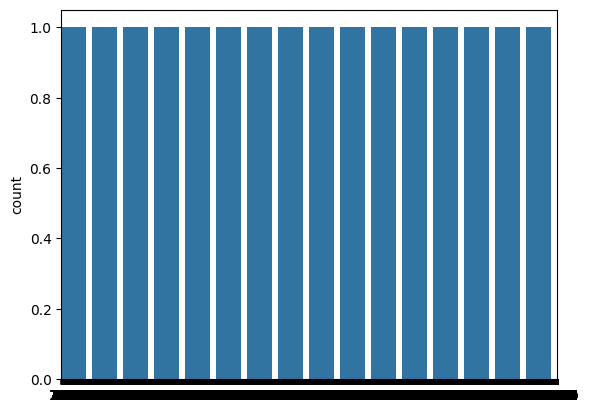

In [ ]:
# Load the data, MNIST is nowadays incorporated in Keras/Tensorflow, so rather easy to use

(x_train, x_train_label), (x_test, x_test_label) = mnist.load_data()
#(x_train, x_train_label), (x_test, x_test_label) = fashion_mnist.load_data() # In case you want to try fashion mnist

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Show the dimensions
print(x_train.shape)
print(x_test.shape)

# verify the labels are distributed evenly
g = sns.countplot(x_train_label)

In [ ]:
# Define the autoencoder model

# These are the dimensions of the original input, the intermediate layer and latent layer
original_dim = 784
intermediate_dim = 256
latent_dim = 2 #

# autoencoder model
# In this example I used 2 dense neural network layers. You could also use deeper structures or RNN/LSTM or convolutional layers
# The encoder and decoder don't have to be the exact same network structure
input_img = keras.Input(shape=(original_dim,))
encoded = layers.Dense(intermediate_dim, activation='relu')(input_img)
encoded = layers.Dense(latent_dim, activation='relu')(encoded)
# at this point the representation has dimension: latent_dim
decoded = layers.Dense(intermediate_dim, activation='relu')(encoded)
decoded = layers.Dense(original_dim, activation='sigmoid')(decoded)
autoencoder = keras.Model(input_img, decoded, name='autencoder')
print (autoencoder.summary())

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Next the encoder part and decoder model, in order to inspect the inner representation,
# referencing the autoencode layers (the 3 models share there weights)
# This part can be omitted in case you don't want to use the inner latent representation

# encoder model (first part of the autoencoder)
encoder = keras.Model(input_img, encoded, name='encoder')
print (encoder.summary())

# decoder model (second part of the autoencoder) to be able to generate an image from an inner representation,  basically the encoder in reverse.
encoded_input = keras.Input(shape=(latent_dim,))
decoder_layer = autoencoder.layers[-2](encoded_input) # Retrieve the last layers of the autoencoder model
decoder_layer = autoencoder.layers[-1](decoder_layer)
decoder = keras.Model(encoded_input, decoder_layer, name='decoder')
print (decoder.summary())

Model: "autencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 403,730 (1.54 MB)

 Trainable params: 403,730 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,474 (787.01 KB)

 Trainable params: 201,474 (787.01 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,256 (790.06 KB)

 Trainable params: 202,256 (790.06 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Train the autoencoder

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
# Encode and decode some digits, show the inner latent representation

# If you want to show the inner latent representation, use encoder-decoder lines
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
# If you are not interested in the inner latent representation, use the autoencoder line directly
#decoded_imgs = autoencoder.predict(x_test)

#Show results: original, encode inner latent representation, decoded image
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.set_xlabel("{}".format(np.array2string(encoded_imgs[i],max_line_width=10)))
    plt.gray()
    ax.get_yaxis().set_visible(False)
    ;
plt.show()

In [ ]:
# Showcase the inner hidden/latent space by plotting all the test images on the latent space
x_test_encoded = encoder.predict(x_test, batch_size=128)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=x_test_label, cmap='rainbow')
plt.colorbar()
plt.show()

In [ ]:
@interact

def morph(x = 150, y=150):
    x_decoded = decoder.predict(np.array([[x, y]]))
    plt.imshow(x_decoded.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return plt.figure()